In [1]:
from importlib import reload
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import fairpol.predpol as fp
import fairpol.assesspol as ap
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import scipy as sp

In [2]:
from matplotlib import rc
rc('figure', **{ 'figsize' : (14, 8) })
rc('font', **{ 'size' : 20 })
rc('animation', html='jshtml')

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [4]:
chicago = pd.read_csv('../data/ChicagoHomicides2012to2017.csv', parse_dates=['Date'])
train_idx = chicago.Year <= 2014
train = chicago.loc[train_idx]
test_idx = chicago.Year == 2015
test = chicago.loc[test_idx]

In [5]:
pp = fp.PredPol(train, grid_size=0.01)

In [6]:
len(pp.grid_cells)

48475

In [7]:
# pp.fit()
# pp.omega, pp.sigma, pp.eta
pp.omega, pp.sigma, pp.eta = (5.917576884767137, 0.0001143914018379195, 0.45282928154899593)

# Accuracy Assessment

In [8]:
results = ap.AssessPol(pp)
days = sp.arange('2015-01-01', '2015-12-31', dtype='datetime64[D]')
results = results.generate_predictions(chicago, days)

100%|██████████| 364/364 [1:48:18<00:00, 19.64s/it]


In [10]:
with open('results_daily_2015.p', 'ab+') as f:
    pickle.dump(results, f)
    # results = pickle.load(f)
    pass

In [11]:
results.get_predicted_intensities().describe()

,2015-01-01_lambda,2015-01-02_lambda,2015-01-03_lambda,2015-01-04_lambda,2015-01-05_lambda,2015-01-06_lambda,2015-01-07_lambda,2015-01-08_lambda,2015-01-09_lambda,2015-01-10_lambda,...,2015-12-21_lambda,2015-12-22_lambda,2015-12-23_lambda,2015-12-24_lambda,2015-12-25_lambda,2015-12-26_lambda,2015-12-27_lambda,2015-12-28_lambda,2015-12-29_lambda,2015-12-30_lambda
count,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,...,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000,48475.000000
mean,1241.277426,1241.277426,1241.277426,1241.661688,1241.661688,1242.060531,1243.008315,1243.008315,1243.421307,1243.821081,...,1404.456839,1405.106920,1405.106920,1405.749591,1406.307369,1406.639027,1407.330124,1408.221111,1408.511417,1408.781084
std,3532.796640,3532.796640,3532.796640,3532.850586,3532.850586,3532.896852,3533.272504,3533.272504,3533.432070,3533.518579,...,3595.551950,3595.705409,3595.705409,3595.993225,3596.163640,3596.269427,3596.492474,3596.919971,3596.944484,3597.100448
min,2.544970,2.544970,2.544970,2.544970,2.544970,2.579261,2.579289,2.579289,2.579289,2.579354,...,3.223379,3.223379,3.223379,3.223379,3.226267,3.226308,3.226308,3.229823,3.229823,3.229826
25%,192.005000,192.005000,192.005000,192.253414,192.253414,192.467427,192.542305,192.542305,192.714470,192.748225,...,267.236084,267.844961,267.844961,268.291825,268.517174,268.545912,268.846465,268.993073,269.387475,269.468367
50%,367.872178,367.872178,367.872178,368.165049,368.165049,368.537002,369.030560,369.030560,369.450883,369.639530,...,507.686076,508.498979,508.498979,509.107336,509.601104,509.766065,510.575686,511.224561,511.536621,511.731935
75%,603.082771,603.082771,603.082771,603.567138,603.567138,604.090354,605.272700,605.272700,605.765266,606.466820,...,826.236400,826.827606,826.827606,827.537089,828.485573,828.923085,829.897881,831.374841,831.601583,831.973016
max,73435.799144,73435.799144,73435.799144,73436.503115,73436.503115,73436.707380,73436.936952,73436.936952,73437.810695,73438.322627,...,74669.807949,74671.231700,74671.231700,74672.602825,74672.915626,74673.324781,74675.027156,74676.313142,74676.746301,74676.790800


In [13]:
results.get_actual_counts().values.sum(), len(test)

(502, 502)

In [16]:
accuracy = results.compute_accuracy()

100%|██████████| 364/364 [00:03<00:00, 101.11it/s]


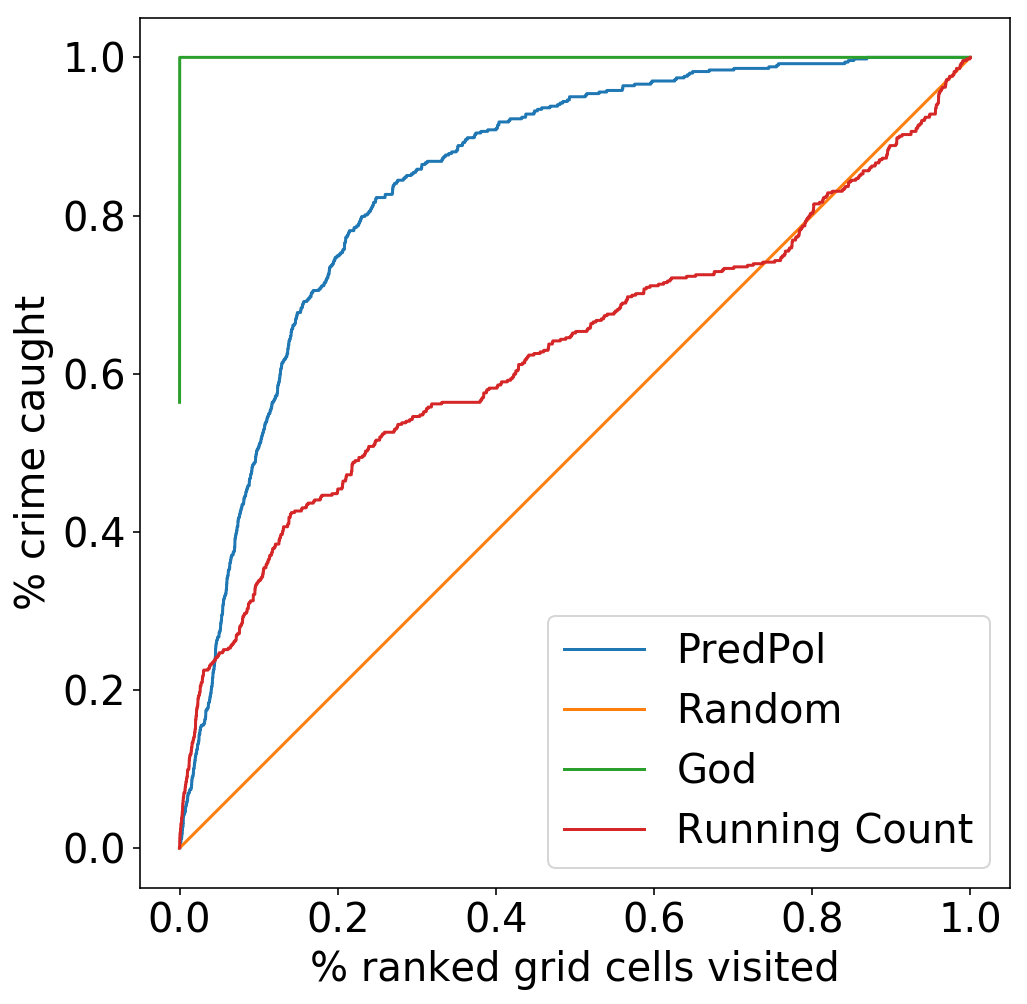

In [17]:
fraction_flagged = sp.arange(0.0, 1.0, 1.0 / len(accuracy))
plt.plot(fraction_flagged, accuracy['predpol'], label='PredPol')
plt.plot(fraction_flagged, fraction_flagged, label='Random')
plt.plot(fraction_flagged, accuracy['god'], label='God')
plt.plot(fraction_flagged, accuracy['running_count'], label='Running Count')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('% ranked grid cells visited')
plt.ylabel('% crime caught')
plt.show()

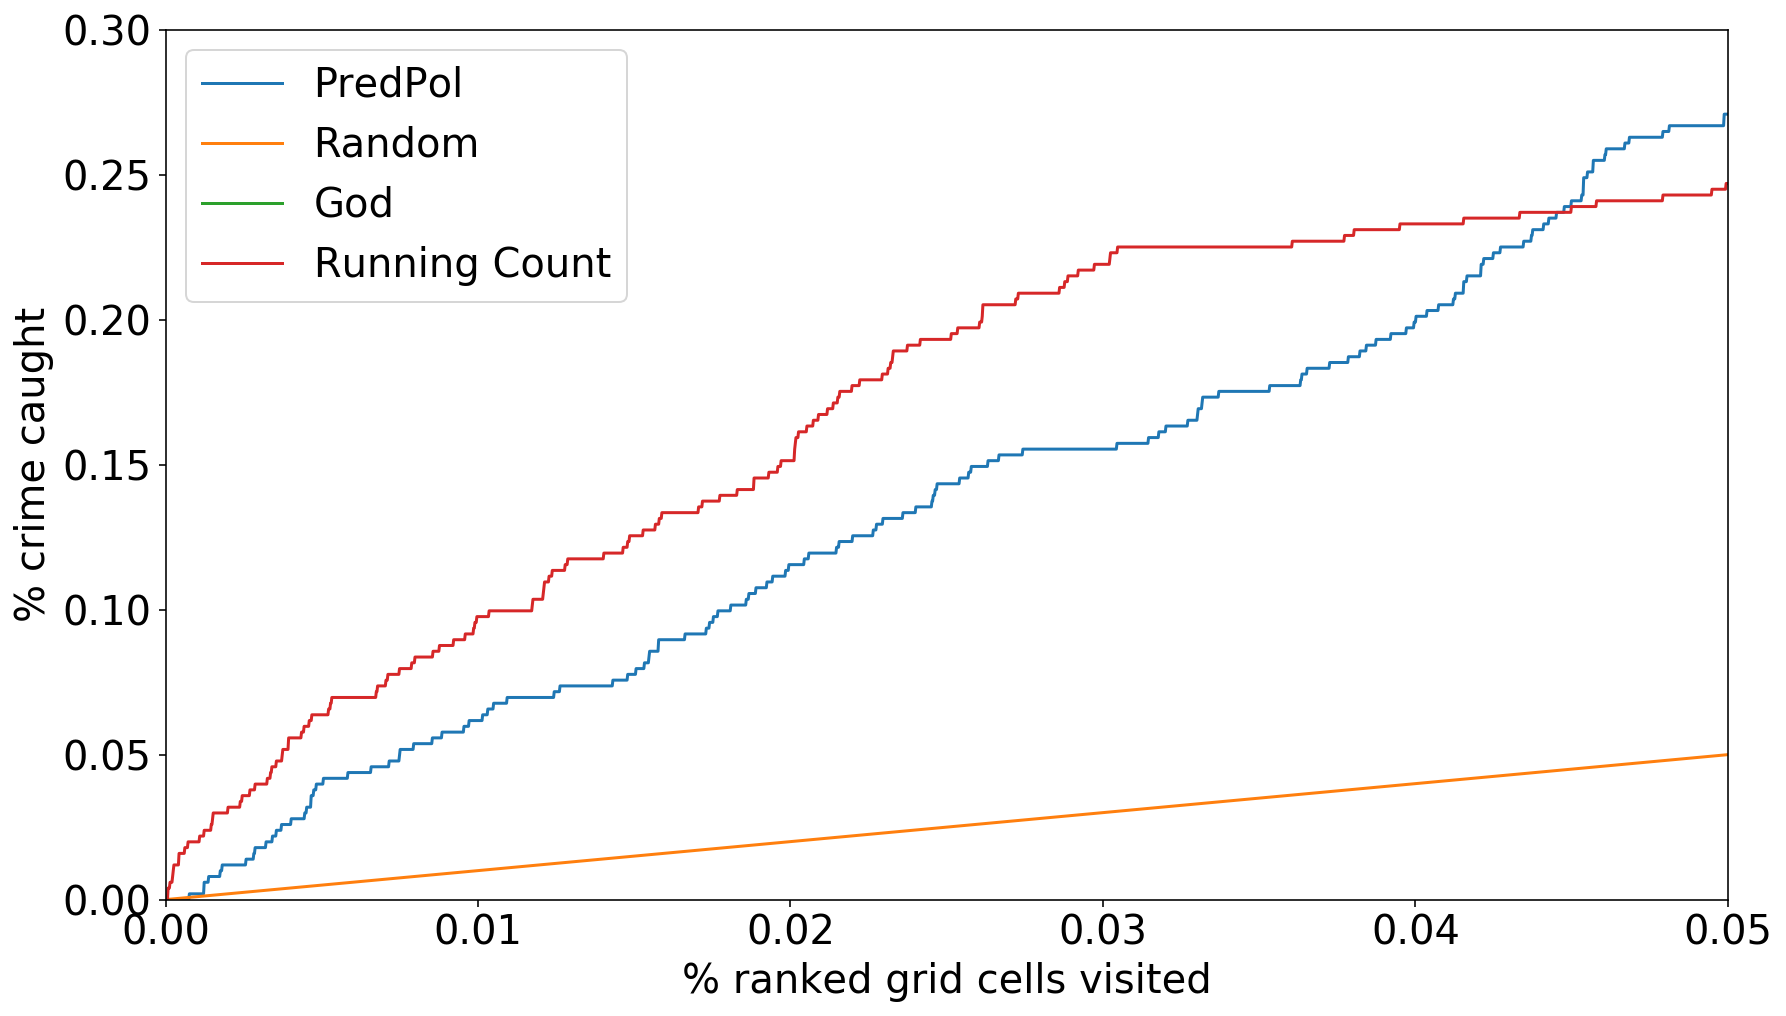

In [22]:
fraction_flagged = sp.arange(0.0, 1.0, 1.0 / len(accuracy))
plt.plot(fraction_flagged, accuracy['predpol'], label='PredPol')
plt.plot(fraction_flagged, fraction_flagged, label='Random')
plt.plot(fraction_flagged, accuracy['god'], label='God')
plt.plot(fraction_flagged, accuracy['running_count'], label='Running Count')
plt.legend()
plt.xlabel('% ranked grid cells visited')
plt.ylabel('% crime caught')
plt.xlim((0, 0.05))
plt.ylim((0, 0.30))
plt.show()